# SURF (Speeded-Up Robust Features、頑健な特徴量の高速化)の紹介
## 目的
このチュートリアルでは:
* SURFの基礎を学ぶ
* OpenCVにおけるSURFの関数について学ぶ


## 理論
参考: [藤吉氏によるSURFの日本語解説](http://www.vision.cs.chubu.ac.jp/CV-R/jpdf/HerbertECCV2006.pdf):ヘッセ行列、ボックス・フィルタ、積分画像についての説明あり

前の章では、キーポイント検出と特徴量記述子を扱う SIFT について学んだ。しかしながらこの手法は比較的遅いものであり、高速化バージョンが望まれていた。2006年にBay, H., Tuytelaars, T. & Van Gool, L は “SURF: Speeded Up Robust Features” 論文で、SURFというアルゴリズムを提案した。名前が示すように、これはSIFTの高速化バージョンである。

SIFTではスケール空間を見つけ出すためにLoG(ガウシアンのラプラシアン)をDoG(ガウシアンの差分)で近似していた。SURFではそれをもう少し進めて、LoGをボックス・フィルタで近似する。下の図はこの近似を示している。この方法の大きな利点は、ボックス・フィルタによる畳込みが積分画像の助けにより簡単に計算できるということである。しかもいろいろなスケールでの計算が並列で行える。SURFはまた、スケールと位置の両方に対しヘッセ行列の行列式を用いている。

![Box Filter approximation of Laplacian](http://lang.sist.chukyo-u.ac.jp/Classes/OpenCV/_images/surf_boxfilter.jpg)

向きの計算に対して、SURFはキーポイントを中心としたサイズ$6\times s$ (sはスケール)の周辺領域に対する水平方向と垂直方向のHaarウェーブレット応答を用いる。適切なガウス重みも適用される。そして、下図に示すような空間で表現する。60度の角度を持つウィンドゥをずらしながら、そのウィンドゥの中のすべての応答値の合計を計算して、最大の向きを決定する。ここで面白いことに、ウェーブレット応答はどのスケールに対しても積分画像を用いて簡単に計算できる。 多くの応用において回転不変は要求されず、したがって向きの計算が必要とされない、これにより高速化が図れる。SURFが与えるこのような機能をアップライトSURF, もしくは U-SURFF と呼ぶ。SURFは高速性を改善し、頑健さも $\pm 15^{\circ}$まで改善している。OpenCVはフラグuprightの値によってSURFもU-SURFもサポートしている。もしもuprightフラグの値が 0であれば、向きの計算が行われ、1であれば向きを計算せず、より高速に計算が行われる。

![Orientation Assignment in SURF](http://lang.sist.chukyo-u.ac.jp/Classes/OpenCV/_images/surf_orientation.jpg)
特徴量記述子に対しても, SURFはキーポイント周りの水平方向と垂直方向のHaarウェーブレット応答を用いる(またもや積分画像により計算が簡単になっている)。キーポイントを中心としたサイズ$20s\times 20s$(sはスケール)の周辺領域を対象とする。これを$4\times 4$ に分割する。分割領域それぞれに対し、水平方向と垂直方向のウェーブレット応答を取り出し、次のようなベクトルを作る:$v=( \sum{d_x}, \sum{d_y}, \sum{|d_x|}, \sum{|d_y|})$. これにより合計(16個の分割領域×4次元=）64次元のベクトルができ、これをSURFの特徴記述子の表現とする。次元を削減すれば特徴記述子の計算とマッチングを速く行えるが、特徴の弁別性能が悪くなる。

特徴の弁別性能をあげるために、SURFの特徴記述子には128次元の拡張版がある。 $d_x$ と$|d_x|$の合計は$ d_y < 0 $と$ d_y \geq 0$という条件別に計算される。同様に、 $d_y$ と $|d_y|$ の合計の計算も$d_x$の正負によって別に行われ、それにより特徴量の数が2倍になっている。そうであっても、計算コストはあまり増えない。OpenCV ではcv2.SURF()関数のオプションextendedフラグの値が 0 か 1 によって 64次元と 128次元を切り替えられるようにしている(デフォルトは 64次元である)。

SIFTに対するSURFのもう一つ重要な改良点は、関心点の検出にラプラシアンの符号(ヘッセ行列のトレース)を用いていることである。これはすでにキーポイント検出で計算が行われているので、新たな計算コストはかからない。ラプラシアンの符号により、暗い背景にある明るい点とその逆の明るい背景にある暗い点の区別ができる。マッチング段階では、同じタイプのコントラストがある時にだけ特徴比較をすれば良い (下の図で示すように)。符号という最小の情報により、記述子の性能を落とさずに高速にマッチングすることが可能になる。

![Fast Indexing for Matching](http://lang.sist.chukyo-u.ac.jp/Classes/OpenCV/_images/surf_matching.jpg)
要するに、SURFはどの段階においてもスピードをあげるための数多くの特徴を付け加えている。分析によれば、SIFTと比べスピードは3倍速く、性能はほぼ変わらない。SURFはぼかしや回転に強いが、視点変化や明るさの変化には弱い。

## OpenCVのSURF
OpenCVではSIFT同様、SURF関数群を提供している。まずヘッセ閾値をいくらにするか(hessianThreshold)、64次元と128次元のどちらの記述子を使うか(extended)、アップライトSURFか通常のSURFのどちらにするか(upright)、などのオプションを[cv2.xfeatures2d.SURF_create({, hessianThreshold{, nOctaves{, nOctaveLayers{, extended{, upright}}}}})](http://docs.opencv.org/3.0-beta/modules/xfeatures2d/doc/nonfree_features.html?highlight=cv2.surf#cv2.SURF)関数に与えてSURFオブジェクトを作る。詳しくはドキュメントを参照のこと。次にSIFTで行ったように、[SURF.detect()](http://docs.opencv.org/3.0-beta/modules/xfeatures2d/doc/nonfree_features.html?highlight=cv2.surf#cv2.SURF.detect)関数や [SURF.compute()](http://docs.opencv.org/3.0-beta/modules/xfeatures2d/doc/nonfree_features.html?highlight=cv2.surf#cv2.SURF.compute)関数を用いてキーポイント特徴記述子を計算する。

最初に、SURFキーポイントと特徴量記述子の見つけ方とその表示について、簡単なデモを示す。これらの例はすべてPythonターミナルで行っている:([画像](http://lang.sist.chukyo-u.ac.jp/Classes/OpenCV/py_tutorials/py_feature2d/py_surf_intro/fly.png))

In [22]:
import cv2
img = cv2.imread('fly.png',0)

# SURFオブジェクトを作る。ここでパラメタを設定しても良いが、あとでもできる
# ここではヘッセの閾値を 400 に設定した
surf = cv2.xfeatures2d.SURF_create(400)

# 直接キーポイントと特徴量記述子を求める
kp, des = surf.detectAndCompute(img,None)

len(kp)
# 原文では699

372

372個のキーポイントは図示するには数が多すぎるので、50個位にへらしたい。マッチングの時にはこれらすべて必要となるかもしれないが、今はやめておこう。そこで、ヘッセの閾値を増やしてみる。

In [23]:
# ヘッセ閾値の現在の値をチェックする
print (surf.getHessianThreshold())

400.0


In [24]:
# この値を5000くらいにする。この変更は図で書くためだけの変更であることに注意。
# 実際には、ヘッセ閾値は300〜500の間の値にしたほうが良い
surf.setHessianThreshold(6000) 

# 再度キーポイントを計算し、その個数をチェックする
kp, des = surf.detectAndCompute(img,None)

In [25]:
print (len(kp))

46


これで50個以下になった。そこでこれを図にしてみよう。

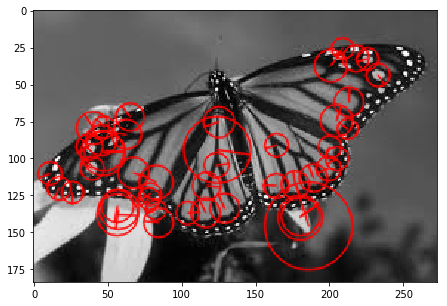

In [27]:
%matplotlib inline
import matplotlib.pyplot as plt
img2 = cv2.drawKeypoints(img,kp,None,(255,0,0),4)

plt.figure(figsize=(12,5))
plt.imshow(img2)
plt.show()

この結果からSURFはコーナー検出器というよりシミ検出器と呼ぶべきものであることが分かるだろう。実際に蝶の羽の模様を検出している。いろいろな画像で試してみよう。

さて、次に U-SURFを試そう。これは向きの検出をしないことに注意。

In [12]:
#  uprightフラグのチェック、FalseならばTrueにセットする
print (surf.getUpright())

False


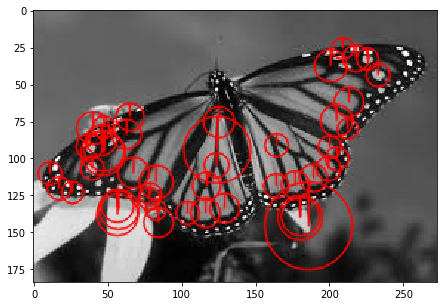

(<matplotlib.image.AxesImage at 0x7f5fb014dac8>, None)

In [15]:
# Trueにする
surf.setUpright(True)

# 特徴点を再計算し、再度描画する
kp = surf.detect(img,None)
img2 = cv2.drawKeypoints(img,kp,None,(255,0,0),4)

plt.figure(figsize=(12,5))
plt.imshow(img2),plt.show()

すべての向きが同じ向き(uprightー直立)になっている。U-SURFの方が先の(Normalな)方法よりも計算スピードが早い。だから(パノラマ写真を作る時のように)向きの検出が不要ならこの方法の方が良い。

最後に特徴量記述子のサイズを調べ、64次元の場合と128次元の場合で比べてみよう:

In [29]:
# 特徴記述子のサイズを調べる
print (surf.descriptorSize())

64


In [30]:
# これはつまり "extended" フラグが False だったということ
surf.getExtended()

False

In [31]:
# そこで128次元の記述子をえるためTrueに変える
surf.setExtended(True)
kp, des = surf.detectAndCompute(img,None)
print (surf.descriptorSize())


128


In [33]:
print (des.shape)

(46, 128)


残るはマッチングであるが、これは後続の章で扱う。

## 補足資料
Bay, H., Ess, A., Tuytelaars, T. & Van Gool, L. (2008). [SURF: Speeded Up Robust Features](ftp://ftp.vision.ee.ethz.ch/publications/articles/eth_biwi_00517.pdf). Computer Vision and Image Understanding (CVIU). 110(3). pp.346--359.